In [1]:
import os
import time
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from pandas.tseries.offsets import BDay
import yfinance as yf

%matplotlib inline

### Date Functions

In [2]:
# index membership
def get_index_constituents(index_ticker: str) -> pd.DataFrame:
    """
    This function reads the hard coded file index_ticker.csv from data folder to get constituents of an index
    """
    index_ticker = index_ticker.upper()
    fname = f'data/{index_ticker}.csv'
    if os.path.exists(fname):
        idx_decomp = pd.read_csv(fname)
        return idx_decomp
    else:
        raise NotImplementedError(f'Data for {index_ticker} is not found.')

#### The following function downloads market data of constituents of an index and cache it

<p>It was found that yfinance can be stuck in the middle of downloading a bunch of tickers. Thus we also use files to cache data for individual stocks. If this function is stuck, try to run it a few times such that all the tickers are ready</p>

In [3]:
def fetch_yfin_constituent_market_data(index_ticker: str) -> pd.DataFrame:

    constituent_df = get_index_constituents(index_ticker)
    tickers = constituent_df['Symbol']
    # check if locally cached
    cache_fname = f'data/yfin_{index_ticker}_constituent_mkt_data.csv'
    yest = pd.datetime.today() - BDay(1)
    if os.path.exists(cache_fname):
        # if the data is outdated by at least one day, we download and refresh
        last_fetch_dt = dt.datetime.fromtimestamp(os.path.getmtime(cache_fname)).date()
        should_fetch = (last_fetch_dt < yest.date())
    else:
        should_fetch = True

    if should_fetch:
        batch_res = []
        for t in tickers:
            ticker_fname = f'data/yfin_{t}.csv'
            if os.path.exists(ticker_fname):
                last_fetch_dt = dt.datetime.fromtimestamp(os.path.getmtime(ticker_fname)).date()
                ticker_fetch = (last_fetch_dt < yest.date())
            else:
                ticker_fetch = True
            if ticker_fetch:
                ticker = yf.Ticker(t)
                print('Downloading', t)
                d = ticker.history(start='2012-01-01')
                d.columns = pd.MultiIndex.from_product([d.columns.tolist(), [t]])
                d.to_csv(ticker_fname)
                d.index = pd.to_datetime(d.index)
                time.sleep(0.5)
            else:
                d = pd.read_csv(ticker_fname, header=[0, 1], index_col=0)
                d.index = pd.to_datetime(d.index)
            batch_res.append(d)
        res = pd.concat(batch_res, axis=1, ignore_index=False, sort=True)
        # res = yf.download(' '.join(tickers[0:10]), start='2020-01-01')
        res.to_csv(cache_fname)
    else:
        res = pd.read_csv(cache_fname, header=[0, 1], index_col=0)

    # res.index = pd.to_datetime(res.index)
    return res

### Define the strategy

In [4]:
class MomentumStrategy:

    def __init__(self, **kwargs):

        self._short_momentum_days = kwargs.get('short_momentum_days', 20)
        self._mid_momentum_days = kwargs.get('mid_momentum_days', 40)
        self._long_momentum_days = kwargs.get('long_momentum_days', 60)

        self._n_top = kwargs.get('n_top', 20)
        self._nb_rebal_days = kwargs.get('nb_rebalance_days', 22)
        self._rebal_days = []
        self._last_trade_date = None

        self._trade_size = 1_000_000

    @property
    def rebalance_days(self):
        return self._rebal_days.copy()

    def on_data(self, this_date, prev_date, next_date, mkt_data: pd.DataFrame, position: pd.DataFrame):

        if len(mkt_data) < self._long_momentum_days:
            return
        elif self._last_trade_date and np.busday_count(self._last_trade_date, this_date) < self._nb_rebal_days:
            return

        px_type = 'Close'
        short_momentum = mkt_data.iloc[-1][(px_type, slice(None))] / \
                         mkt_data.iloc[-self._short_momentum_days][(px_type, slice(None))] - 1

        mid_momentum = mkt_data.iloc[-1][(px_type, slice(None))] / \
                       mkt_data.iloc[-self._mid_momentum_days][(px_type, slice(None))] - 1

        long_momentum = mkt_data.iloc[-1][(px_type, slice(None))] / \
                        mkt_data.iloc[-self._long_momentum_days][(px_type, slice(None))] - 1


        short_momentum = short_momentum.dropna()
        mid_momentum = mid_momentum.dropna()
        long_momentum = long_momentum.dropna()

        # rank
        short_momentum = short_momentum.rank(pct=True)
        mid_momentum = mid_momentum.rank(pct=True)
        long_momentum = long_momentum.rank(pct=True)

        comb_score = short_momentum + mid_momentum + long_momentum

        top_names = comb_score.nlargest(self._n_top)

        pos = position.loc[prev_date]
        long_pos = pos[pos > 0]

        sell_names = set(long_pos.index).difference(top_names.index)
        buy_names = set(top_names.index).difference(long_pos.index)

        if buy_names:
            print(f'[{this_date}]', 'Buying', ', '.join(buy_names))
            position.loc[this_date, buy_names] = self._trade_size
        if sell_names:
            print(f'[{this_date}]', 'Selling', ', '.join(sell_names))
            position.loc[this_date, sell_names] = 0

        self._last_trade_date = this_date
        self._rebal_days.append(self._last_trade_date)
        return pos

### Performance Related Functions

#### Calcualte the summary of performance

In [5]:
def calc_return_ts(position: pd.DataFrame, rebal_days: list) -> pd.Series:

    ret_ts = []
    if position.index[-1] > rebal_days[-1]:
        rebal_days.append(position.index[-1])
    for i in range(1, len(rebal_days)):
        pos = position.loc[rebal_days[i-1]: rebal_days[i]].iloc[:-1]
        if not pos.empty:
            ret = pos.sum(axis=1) / pos.shift(1).sum(axis=1) - 1
            # remove the rebalance day
            ret = ret[1:]
            ret_ts.append(ret)

    ret_ts = pd.concat(ret_ts, sort=True)
    ret_ts = ret_ts.rename('daily_return')
    return ret_ts


def calc_performance_summary(daily_ret_ts, risk_free_rate=0):

    accum_ret = (daily_ret_ts + 1).prod() - 1
    nb_years = len(daily_ret_ts) / 252
    annualized_ret = (accum_ret + 1) ** (1 / nb_years) - 1
    volatility = daily_ret_ts.std(ddof=1)
    annualized_vol = volatility * np.sqrt(252)
    # assume benchmark return is 0
    sharpe_ratio = np.sqrt(252) * (np.mean(daily_ret_ts) - risk_free_rate) / volatility
    cum_ret = (daily_ret_ts + 1).cumprod()
    max_ret = np.maximum.accumulate(cum_ret.values)
    drawdown = (cum_ret.values - max_ret) / max_ret
    max_drawdown = np.min(drawdown)

    return {
        'Start Date': daily_ret_ts.index[0],
        'Accumulated Return': f'{accum_ret:.2%}',
        'Annualized Return': f'{annualized_ret:.2%}',
        'Anualized Volitality': f'{annualized_vol:.2%}',
        'Sharpe': f'{sharpe_ratio:.2f}',
        'Max Drawdown': f'{max_drawdown:.2%}',
    }


#### Draw Charts of Time Series

In [6]:
def draw_charts(daily_ret_ts):

    cum_ret = (daily_ret_ts + 1).cumprod()
    max_ret = np.maximum.accumulate(cum_ret.values)
    drawdown = (cum_ret.values - max_ret) / max_ret
    drawdown *= 100
    cum_ret *= 100

    drawdown = pd.Series(data=drawdown, index=daily_ret_ts.index)
    
    fig, axes = plt.subplots(1, 2, figsize=(14.69, 6.27))
    
    cum_ret.index = pd.to_datetime(cum_ret.index)
    drawdown.index = pd.to_datetime(drawdown.index)
    
    cum_ret.plot(ax=axes[0], title='Accumulated Return (%)')
    drawdown.plot(ax=axes[1], title='Max Drawdown (%)')
    plt.show()

### Driver

In [9]:
def run_backtest():

    index_ticker = 'SP100'
    mkt_data = fetch_yfin_constituent_market_data(index_ticker)

    strategy = MomentumStrategy()

    position = pd.DataFrame(columns=mkt_data.columns.levels[1], index=mkt_data.index, data=0)

    for idx in range(1, len(mkt_data) - 1):
        prev_date, this_date, next_date = mkt_data.index[idx - 1: idx + 2]
        strategy.on_data(this_date, prev_date, next_date, mkt_data.iloc[0: idx + 1], position)
        # roll the position
        ret = mkt_data.loc[next_date, ('Close', slice(None))] / mkt_data.loc[this_date, ('Close', slice(None))]
        ret.index = ret.index.droplevel(0)
        position.loc[next_date] = position.loc[this_date] * ret

    # performance analysis
    daily_ret = calc_return_ts(position, strategy.rebalance_days)
    print('Done.')
    return daily_ret

### Perform backtesting

In [10]:
daily_ret = run_backtest()

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys


[2012-03-28] Buying TSLA, SCHW, COF, BK, LOW, BAC, ACN, QCOM, CRM, BKNG, JPM, AAPL, SBUX, USB, C, AMZN, HD, AXP, GS, WFC
[2012-04-27] Buying V, MO, ABT, KO, GILD, T, AIG, SPG, MA
[2012-04-27] Selling TSLA, SCHW, BK, BAC, QCOM, JPM, C, WFC, GS
[2012-05-29] Buying PEP, CHTR, DIS, SO, UNP, TGT, WMT, VZ, CVS, CL, AMT, NEE, DUK, LLY
[2012-05-29] Selling V, COF, LOW, ACN, CRM, AAPL, USB, SBUX, AIG, SPG, HD, AXP, MA, BKNG
[2012-06-28] Buying V, MRK, GE, JNJ, HD, AMGN, UNH, COST, CMCSA
[2012-06-28] Selling PEP, SO, TGT, ABT, CVS, KO, GILD, AMZN, LLY
[2012-07-30] Buying COF, CVX, TMUS, WBA, ORCL, TMO, GILD, USB, AVGO
[2012-07-30] Selling GE, JNJ, VZ, HD, UNH, AMT, DUK, COST, CMCSA
[2012-08-29] Buying MET, GOOG, TGT, JPM, AAPL, EMR, C, GOOGL, NVDA, RTX, AMZN, AIG, HD, GS, CSCO
[2012-08-29] Selling V, COF, CVX, CHTR, DIS, MRK, UNP, MO, WBA, WMT, CL, T, NEE, USB, AVGO
[2012-09-28] Buying GM, LOW, GE, MS, ACN, BAC, CRM, IBM, PG, MDT, CMCSA, LLY
[2012-09-28] Selling MET, TGT, ORCL, AAPL, EMR, AMGN, 

[2016-11-18] Buying CVX, TMUS, BK, TGT, GD, FDX, LMT, USB, BA, WFC
[2016-11-18] Selling NFLX, GOOG, QCOM, AAPL, GOOGL, ADBE, AMZN, AIG, MA, BKNG
[2016-12-20] Buying GM, DIS, BLK, EMR, UNH, COP, T
[2016-12-20] Selling BK, MET, TGT, GD, LMT, BA, CAT
[2017-01-19] Buying TSLA, NFLX, EXC, CHTR, UNP, GD, MO, AAPL, AXP, BA, CMCSA, AVGO
[2017-01-19] Selling COF, CVX, MS, FDX, BLK, JPM, C, UNH, COP, T, USB, WFC
[2017-02-21] Buying MS, CRM, ABT, AMGN, ADBE, NKE, TMO, CL, NEE, PM, COST, CSCO, LLY
[2017-02-21] Selling SCHW, NFLX, EXC, GM, TMUS, DIS, UNP, GD, MO, NVDA, AXP, GS, CMCSA
[2017-03-23] Buying V, PEP, FB, LOW, DUK, ORCL, JNJ, MMM, ABBV, AMT, MDT, HD, BKNG
[2017-03-23] Selling TSLA, CHTR, BAC, MS, CRM, EMR, ABT, AMGN, NKE, TMO, COST, BA, CSCO
[2017-04-24] Buying TSLA, CHTR, GOOG, WMT, SBUX, UNH, AMZN, HON, MCD, MA
[2017-04-24] Selling JNJ, MMM, ABBV, AVGO, CL, NEE, PM, MDT, DUK, LLY
[2017-05-24] Buying NFLX, PYPL, CRM, LIN, GOOGL, NVDA, RTX, TMO, KO, NEE, AVGO
[2017-05-24] Selling PEP, V, 

[2021-06-11] Buying TMUS, FB, MS, TGT, GOOG, CRM, F, GOOGL, NVDA, ADBE, RTX, COP, AMT, SPG, AXP, LLY
[2021-06-11] Selling BK, BAC, FDX, LIN, PFE, KHC, ABBV, UNH, CVS, MDLZ, T, AIG, PM, UPS, USB, WFC
[2021-07-13] Buying PYPL, ACN, DHR, MSFT, AAPL, NKE, TMO, AMZN, COST
[2021-07-13] Selling COF, TMUS, MS, CRM, F, IBM, RTX, COP, SPG
[2021-08-12] Buying TSLA, COF, BK, CHTR, MS, PFE, EMR, NEE, AIG, GS, WFC
[2021-08-12] Selling PYPL, FB, ACN, ORCL, BLK, MSFT, AAPL, TMO, AMT, AMZN, AXP
[2021-09-13] Buying NFLX, EXC, FB, LOW, ACN, LIN, CSCO, SPG, BKNG
[2021-09-13] Selling COF, BK, TGT, PFE, EMR, ADBE, NKE, WFC, LLY
[2021-10-13] Buying SCHW, CVX, GM, BK, XOM, MET, BAC, CRM, ORCL, F, RTX, TMO, COP, USB
[2021-10-13] Selling EXC, FB, CHTR, MS, ACN, GOOG, LIN, DHR, GOOGL, CSCO, NVDA, NEE, COST, GS
[2021-11-12] Buying UNP, ACN, QCOM, MSFT, DD, NVDA, CVS, UPS, COST, AVGO
[2021-11-12] Selling SCHW, MET, BAC, ORCL, RTX, TMO, COP, AIG, USB, BKNG
[2021-12-14] Buying PEP, ORCL, PFE, AAPL, ABBV, UNH, PG, KO

#### Performance Measurement

In [11]:
perf_summary = calc_performance_summary(daily_ret)
perf_summary

{'Start Date': '2012-03-29',
 'Accumulated Return': '402.25%',
 'Annualized Return': '18.38%',
 'Anualized Volitality': '17.87%',
 'Sharpe': '1.03',
 'Max Drawdown': '-28.47%'}

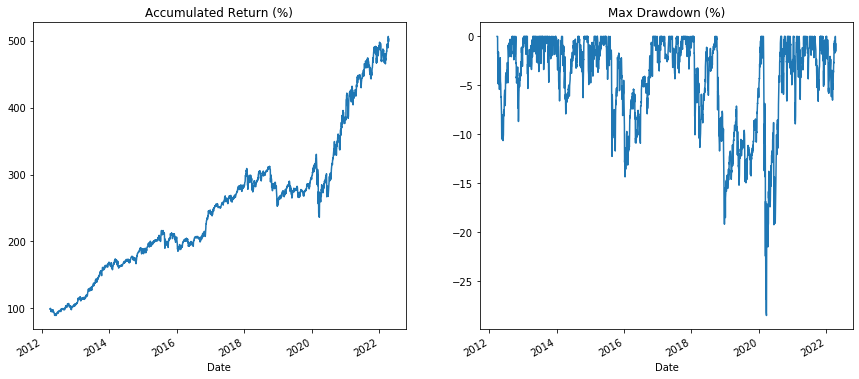

In [12]:
draw_charts(daily_ret)